## Setup: Initialize workspace, create model, define inference functions

In [2]:
!pip install -U sentence-transformers 


     |████████████████████████████████| 71kB 2.3MB/s 
     |████████████████████████████████| 1.3MB 5.5MB/s 
     |████████████████████████████████| 890kB 17.6MB/s 
     |████████████████████████████████| 2.9MB 21.7MB/s 
     |████████████████████████████████| 1.1MB 37.6MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.3.9-cp36-none-any.whl size=101036 sha256=ce719996ccf999252118b5dee2f6dbf31fb4171b965256aaee0b5aac9b58ac1e
  Stored in directory: /root/.cache/pip/wheels/fc/89/43/f2f5bc00b03ef9724b0f6254a97eaf159a4c4ddc024b33e07a
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=bf124c6c1b62ec2aa8c1f0e5f02954df45f53ae82e08772ccbf5e7a9e7d0940b
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sentence-transformers sacremoses


In [3]:
import pandas as pd
import numpy as np
import os
import sys
import torch
import matplotlib.pyplot as plt
import pickle 
from sklearn.preprocessing import MultiLabelBinarizer
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from sentence_transformers import SentenceTransformer
import warnings
import pickle
warnings.filterwarnings('ignore')


In [4]:
import pandas as pd
import numpy as np
from fastai import *
from fastai.text import *
import os
import sys
import torch
import matplotlib.pyplot as plt
import pickle 
from sklearn.preprocessing import MultiLabelBinarizer
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import warnings
warnings.filterwarnings('ignore')
from torchvision import models
import torch
import torch.nn as nn
from skimage import io, transform
import requests
from io import BytesIO
import ipywidgets as widgets
import re
from PIL import Image

In [5]:
df_labels = pd.read_csv("/content/drive/My Drive/Fellowship.ai/embedder/train.csv")

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
df_labels.head()

,gender,masterCategory,subCategory,articleType,baseColour,season,usage,fpath,labels
0,Women,Apparel,Topwear,Tops,White,Summer,Casual,training_img/40435.jpg,Women;Apparel;Topwear;Tops;White;Summer;Casual
1,Men,Apparel,Topwear,Tshirts,Black,Fall,Sports,training_img/18612.jpg,Men;Apparel;Topwear;Tshirts;Black;Fall;Sports
2,Women,Accessories,Bags,Handbags,Blue,Winter,Casual,training_img/21998.jpg,Women;Accessories;Bags;Handbags;Blue;Winter;Ca...
3,Women,Accessories,Bags,Backpacks,Blue,Winter,Casual,training_img/25235.jpg,Women;Accessories;Bags;Backpacks;Blue;Winter;C...
4,Men,Footwear,Sandal,Sandals,Blue,Fall,Casual,training_img/8078.jpg,Men;Footwear;Sandal;Sandals;Blue;Fall;Casual


In [7]:
df_levis = df_labels[['fpath', 'gender', 'masterCategory','baseColour','subCategory','articleType','labels']]
df_levis.head()

,fpath,gender,masterCategory,baseColour,subCategory,articleType,labels
0,training_img/40435.jpg,Women,Apparel,White,Topwear,Tops,Women;Apparel;Topwear;Tops;White;Summer;Casual
1,training_img/18612.jpg,Men,Apparel,Black,Topwear,Tshirts,Men;Apparel;Topwear;Tshirts;Black;Fall;Sports
2,training_img/21998.jpg,Women,Accessories,Blue,Bags,Handbags,Women;Accessories;Bags;Handbags;Blue;Winter;Ca...
3,training_img/25235.jpg,Women,Accessories,Blue,Bags,Backpacks,Women;Accessories;Bags;Backpacks;Blue;Winter;C...
4,training_img/8078.jpg,Men,Footwear,Blue,Sandal,Sandals,Men;Footwear;Sandal;Sandals;Blue;Fall;Casual


In [8]:
df_levis.shape

(1983, 7)

In [9]:
df_levis['masterCategory'].unique()

array(['Apparel', 'Accessories', 'Footwear', 'Personal Care', 'Free Items', 'Sporting Goods'], dtype=object)

In [10]:
exluded_items= ['Product', 'Bags', 'Socks', 'Belts', 'Aprons', 'Backpacks', 'Hats', 'Bandanas', 'Scarves', 'Bras', 'Underwear']

In [11]:
df_levis = df_levis[~df_levis['masterCategory'].isin(exluded_items)]
df_levis.head()
df_levis.shape

(1983, 7)

In [12]:
df_levis['masterCategory'].unique()

array(['Apparel', 'Accessories', 'Footwear', 'Personal Care', 'Free Items', 'Sporting Goods'], dtype=object)

In [13]:
Shirts_Tshirts_tops = [ 'TShirts', 'Shirts', 'Henleys', 'Polos', 'Tank Tops', 'Blouses', 'Bodysuits']
overalls_bodysuits = ['Overalls', 'Jumpsuits', 'Shortalls']
pants = ['Sweatpants', 'Leggings', 'Pants']
shorts = ['Shorts']
jeans = ['Jeans']
dresses_skirts = ['Skirts', 'Dresses']
jackets = ['Coats', 'Jackets', 'JeanJacketsandTruckers']
sweatshirts = ['Sweatshirts']

In [14]:
diff = set(['Jeans', 'TShirts', 'JeanJacketsandTruckers', 'Pants', 'Sweatshirts', 'Overalls', 'Shirts', 'Jackets', 'Shorts',
       'Coats', 'Henleys', 'Polos', 'Leggings', 'Blouses', 'Bodysuits', 'Tank Tops', 'Shortalls', 'Sweatpants',
       'Jumpsuits', 'Skirts', 'Dresses']) - set(Shirts_Tshirts_tops + overalls_bodysuits )

In [15]:
diff

{'Coats',
 'Dresses',
 'Jackets',
 'JeanJacketsandTruckers',
 'Jeans',
 'Leggings',
 'Pants',
 'Shorts',
 'Skirts',
 'Sweatpants',
 'Sweatshirts'}

In [16]:
def reduce_item_type(x):
    if x in Shirts_Tshirts_tops:
        return "Shirts, TShirts & Tops"
    elif x in overalls_bodysuits:
        return "Overalls & Jumpsuits"
    elif x in pants:
        return "Pants, Sweatpants, Leggings & Jeggings"
    elif x in shorts:
        return "Shorts"
    elif x in jeans:
        return "Jeans"
    elif x in dresses_skirts:
        return "Skirts & Dresses"
    elif x in jackets:
        return "Coats, Jackets & Truckers"
    elif x in sweatshirts:
        return "Sweatshirts"
    else:
        return "Other"

In [17]:
df_levis["articleType"]=df_levis["articleType"].apply(reduce_item_type)

In [18]:
df_levis['articleType'].unique()

array(['Other', 'Shorts', 'Shirts, TShirts & Tops', 'Coats, Jackets & Truckers', 'Skirts & Dresses', 'Sweatshirts',
       'Jeans', 'Pants, Sweatpants, Leggings & Jeggings'], dtype=object)

In [19]:
df_levis.shape

(1983, 7)

In [20]:
df_levis.columns

Index(['fpath', 'gender', 'masterCategory', 'baseColour', 'subCategory',
       'articleType', 'labels'],
      dtype='object')

In [21]:
df_levis = df_levis.rename(columns={'file_path': 'file_path', 'classifications__apparel__gender': 'gender', 'articleType': 'articleType','labels': 'labels'})

In [22]:
df_levis.columns

Index(['fpath', 'gender', 'masterCategory', 'baseColour', 'subCategory',
       'articleType', 'labels'],
      dtype='object')

In [23]:
df_myntra = pd.read_csv("/content/drive/MyDrive/Fellowship.ai/embedder/fashion_train.csv")
df_myntra.head()


,id,gender,masterCategory,subCategory,articleType,baseColour,season,usage,fname
0,40435,Women,Apparel,Topwear,Tops,White,Summer,Casual,40435.jpg
1,18612,Men,Apparel,Topwear,Tshirts,Black,Fall,Sports,18612.jpg
2,21998,Women,Accessories,Bags,Handbags,Blue,Winter,Casual,21998.jpg
3,25235,Women,Accessories,Bags,Backpacks,Blue,Winter,Casual,25235.jpg
4,8078,Men,Footwear,Sandal,Sandals,Blue,Fall,Casual,8078.jpg


In [24]:
df_myntra.iloc[0,0]

40435

In [25]:
df_myntra_filtered = df_myntra[df_myntra['fname'].apply(lambda x: ".jpg" in x)]

In [26]:
df_myntra_filtered.shape

(1983, 9)

In [27]:
df_myntra.columns

Index(['id', 'gender', 'masterCategory', 'subCategory', 'articleType',
       'baseColour', 'season', 'usage', 'fname'],
      dtype='object')

In [28]:
df_myntra.drop_duplicates().shape

(1983, 9)

In [29]:
df_myntra['articleType'].unique()

array(['Tops', 'Tshirts', 'Handbags', 'Backpacks', ..., 'Jewellery Set', 'Lounge Shorts', 'Gloves', 'Bracelet'],
      dtype=object)

In [30]:
exluded_items = ['Handbags', 'Clutches', 'Duffel Bag', 'Belts', 'Socks', 'Messenger Bag', 'Scarves']
df_myntra = df_myntra[~df_myntra['articleType'].isin(exluded_items)]

In [31]:
df_myntra.shape

(1818, 9)

In [32]:
df_myntra['articleType'].unique()

array(['Tops', 'Tshirts', 'Backpacks', 'Sandals', ..., 'Jewellery Set', 'Lounge Shorts', 'Gloves', 'Bracelet'],
      dtype=object)

In [33]:
Shirts_Tshirts_tops = ['Tshirts', 'Lounge Tshirts', 'Tshirts Smart', 'Shirts', 'Tops', 'Tunics', 'Bodysuit']
overalls_bodysuits = [ 'Jumpsuit', 'Dungarees']
pants = ['Track Pants', 'Leggings', 'Capris', 'Jeggings', 'Trousers']
shorts = ['Shorts', 'Lounge Shorts']
jeans = ['Jeans']
dresses_skirts = ['Dresses', 'Skirts']
jackets = ['Jackets']
sweatshirts = ['Sweatshirts']

In [34]:
diff = set(['Jeans', 'Shorts', 'Lounge Shorts', 'Jackets', 'Sweatshirts', 'Trousers', 'Tshirts', 'Lounge Tshirts',
       'Tshirts Smart', 'Shirts', 'Skirts', 'Jeggings', 'Tops', 'Tunics', 'Bodysuit', 'Track Pants', 'Leggings',
       'Capris', 'Dresses', 'Jumpsuit', 'Dungarees']) - set(Shirts_Tshirts_tops + overalls_bodysuits + pants
                                                            )

In [35]:

diff

{'Dresses',
 'Jackets',
 'Jeans',
 'Lounge Shorts',
 'Shorts',
 'Skirts',
 'Sweatshirts'}

In [36]:
def reduce_item_type(x):
    if x in Shirts_Tshirts_tops:
        return "Shirts, TShirts & Tops"
    elif x in overalls_bodysuits:
        return "Overalls & Jumpsuits"
    elif x in pants:
        return "Pants, Sweatpants, Leggings & Jeggings"
    elif x in shorts:
        return "Shorts"
    elif x in jeans:
        return "Jeans"
    elif x in dresses_skirts:
        return "Skirts & Dresses"
    elif x in jackets:
        return "Coats, Jackets & Truckers"
    elif x in sweatshirts:
        return "Sweatshirts"
    else:
        return "Other"

In [37]:
df_myntra["articleType"]=df_myntra["articleType"].apply(reduce_item_type)

In [38]:
df_myntra['articleType'].unique()

array(['Shirts, TShirts & Tops', 'Other', 'Shorts', 'Coats, Jackets & Truckers', 'Skirts & Dresses',
       'Pants, Sweatpants, Leggings & Jeggings', 'Sweatshirts', 'Jeans'], dtype=object)

In [39]:
df_myntra.columns

Index(['id', 'gender', 'masterCategory', 'subCategory', 'articleType',
       'baseColour', 'season', 'usage', 'fname'],
      dtype='object')

In [40]:
df_myntra_inf=df_myntra.drop_duplicates()

In [41]:
df_myntra_inf.shape

(1818, 9)

In [42]:
df_myntra_inf['articleType'].unique()

array(['Shirts, TShirts & Tops', 'Other', 'Shorts', 'Coats, Jackets & Truckers', 'Skirts & Dresses',
       'Pants, Sweatpants, Leggings & Jeggings', 'Sweatshirts', 'Jeans'], dtype=object)

In [43]:
df_myntra_inf['gender'].unique()

array(['Women', 'Men', 'Unisex', 'Girls', 'Boys'], dtype=object)

In [44]:
df_myntra_inf = df_myntra_inf.rename(columns={'img_path': 'fname', 'gender': 'gender', 'article_type': 'articleType'})

In [45]:
df_myntra_inf.columns

Index(['id', 'gender', 'masterCategory', 'subCategory', 'articleType',
       'baseColour', 'season', 'usage', 'fname'],
      dtype='object')

In [46]:
df_for_inference = pd.concat([df_levis, df_myntra_inf])

In [47]:
df_for_inference.shape

(3801, 11)

In [48]:
df_for_inference.to_csv("levis_myntra_front_inference_v4.csv", index=False)

In [49]:
df_for_inference['articleType'].unique()

array(['Other', 'Shorts', 'Shirts, TShirts & Tops', 'Coats, Jackets & Truckers', 'Skirts & Dresses', 'Sweatshirts',
       'Jeans', 'Pants, Sweatpants, Leggings & Jeggings'], dtype=object)

In [50]:
from nltk.stem import PorterStemmer
porter = PorterStemmer()
print(porter.stem("sadasd"))

sadasd


## Loading encoder and defining neessary classes

In [51]:
data = pd.read_csv('/content/drive/MyDrive/Fellowship.ai/embedder/levis_myntra_front_inference_v4.csv')
data.head()


,fpath,gender,masterCategory,baseColour,subCategory,articleType,labels,id,season,usage,fname
0,training_img/40435.jpg,Women,Apparel,White,Topwear,Other,Women;Apparel;Topwear;Tops;White;Summer;Casual,NaN,NaN,NaN,NaN
1,training_img/18612.jpg,Men,Apparel,Black,Topwear,Other,Men;Apparel;Topwear;Tshirts;Black;Fall;Sports,NaN,NaN,NaN,NaN
2,training_img/21998.jpg,Women,Accessories,Blue,Bags,Other,Women;Accessories;Bags;Handbags;Blue;Winter;Ca...,NaN,NaN,NaN,NaN
3,training_img/25235.jpg,Women,Accessories,Blue,Bags,Other,Women;Accessories;Bags;Backpacks;Blue;Winter;C...,NaN,NaN,NaN,NaN
4,training_img/8078.jpg,Men,Footwear,Blue,Sandal,Other,Men;Footwear;Sandal;Sandals;Blue;Fall;Casual,NaN,NaN,NaN,NaN


In [52]:
label_superset = set()
def get_label_superset(x):
    #print(x)
    label_superset.update(str(x).split(";"))
data['labels'].apply(get_label_superset)
attribute_list=data.labels.to_list()

In [53]:

model=SentenceTransformer('bert-base-nli-mean-tokens')


100%|██████████| 405M/405M [00:45<00:00, 8.83MB/s]


In [54]:
embed_dict={i:model.encode(i) for i in str(attribute_list)}


In [55]:
len(embed_dict)

55

In [56]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.res34=models.resnet34(pretrained=True)
        self.res34.fc=nn.Linear(in_features=512,out_features=768)
        self.n_label=len(embed_dict)   ## Dimensionality of multi hot encoded vector(multilabel)
        self.fc2=nn.Linear(in_features=768,out_features=self.n_label)

    def forward(self,X):
        h1=self.res34(X)
        x=self.fc2(F.relu(h1))
        return h1,x

In [57]:
class ClothesDataset(Dataset):
    """Multilabel clothes dataset."""

    def __init__(self, csv_file, root_dir, embeddings_dict, seperator, classes, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.multilabel_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.embeddings_dict = embeddings_dict
        self.seperator = seperator
        self.classes = classes
        self.encode()
        self.transform = transform


    def __len__(self):
        return len(self.multilabel_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.multilabel_frame.iloc[idx, 0])
        image = io.imread(img_name)
        sample = {'image': image,
                  'img_name': img_name,
                  'labels_w2v_sum': self.multilabel_frame.iloc[idx, 3],
                  'labels_one_hot': self.multi_hot_encoded[idx]}

        if self.transform:
            sample = self.transform(sample)

        return sample
    def get_label_encoding(self, label_list):
        w2v_encoding_list = list()
        for label in label_list:
              w2v_encoding_list.append(self.embeddings_dict[label][0])
        return np.sum(np.array(w2v_encoding_list), axis=0)
        
    def encode(self):
        mlb = MultiLabelBinarizer(classes=self.classes)
        self.multilabel_frame['label_list'] = self.multilabel_frame.iloc[:,1].apply(lambda x: x.split(self.seperator))
        self.multilabel_frame['w2v_list'] =  self.multilabel_frame['label_list'].apply(self.get_label_encoding)
        self.multi_hot_encoded = mlb.fit_transform(self.multilabel_frame['label_list'])
        self.multi_hot_classes = mlb.classes_

In [58]:
class ClothesInference(Dataset):
    """Multilabel clothes dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.multilabel_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform=transform


    def __len__(self):
        return len(self.multilabel_frame)

    def __getitem__(self, idx):
        
        img_name = os.path.join(self.root_dir, self.multilabel_frame.iloc[idx, 0])
        image = io.imread(img_name)
        sample = {'image': image,
                  'img_name': img_name,
                  'gender': self.multilabel_frame.iloc[idx, 1],
                  'item_type': self.multilabel_frame.iloc[idx, 2],
                  }

        if self.transform:
            sample = self.transform(sample)

        return sample

In [59]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image = sample['image']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))
        sample['image'] = img
        return sample

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image = sample['image']
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        sample['image'] = torch.from_numpy(image.transpose((2, 0, 1)))
        sample['labels_w2v_sum'] = torch.from_numpy(sample['labels_w2v_sum'])
        sample['labels_one_hot'] = torch.from_numpy(sample['labels_one_hot'])
  
        return sample


class ToTensorInference(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image = sample['image']
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        sample['image'] = torch.from_numpy(image.transpose((2, 0, 1)))
  
        return sample

In [60]:
embed_dict.keys()

dict_keys(['[', "'", 'W', 'o', 'm', 'e', 'n', ';', 'A', 'p', 'a', 'r', 'l', 'T', 'w', 's', 'h', 'i', 't', 'S', 'u', 'C', ',', ' ', 'M', 'B', 'c', 'k', 'F', 'g', 'H', 'd', 'b', 'J', 'y', 'U', 'x', 'P', 'E', 'K', 'j', 'I', 'f', 'G', 'O', 'N', 'v', 'L', 'R', 'Y', 'D', 'q', 'V', 'z', ']'])

## Making final Inference dataset

In [ ]:
labels_list = list(sorted(embed_dict.keys()))

In [61]:
levis_dataset = ClothesInference(csv_file='/content/drive/MyDrive/Fellowship.ai/embedder/levis_myntra_front_inference_v4_new.csv',
                               root_dir='/content/drive/MyDrive/Fellowship.ai/embedder/',
                               transform=transforms.Compose([
                                               Rescale((256,256)),
                                               ToTensorInference()]))

In [62]:
#split into train and validation
torch.manual_seed(0)
n=len(levis_dataset)
x=1
train_set, val_set = torch.utils.data.random_split(levis_dataset, [int(x*n), n-int(x*n)])

In [63]:
dataloader = DataLoader(levis_dataset, batch_size=512,
                        shuffle=True)

## Extracting the Model Embeddings

In [64]:

net = Model()


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [65]:
from tqdm.notebook import tqdm_notebook
import pickle

df_inference={'img_name':[],'output':[],'h1':[], 'gender': [], 'item_type': []}
i=0
j=0
for data in tqdm_notebook(dataloader):
    i+=1
    net.eval()
    with torch.no_grad():
        #X = data['image'].cuda()
        X = data['image']
        h1,output = net(X.type(torch.float32))
        df_inference['img_name'].extend(data['img_name'])
        df_inference['gender'].extend(data['gender'])
        df_inference['item_type'].extend(data['item_type'])
        df_inference['h1'].extend([np.asarray(x) for x in h1.tolist()])
        df_inference['output'].extend([np.asarray(x) for x in output.tolist()])
        
    

1
1
1
1



In [68]:
with open('Inference_v4_4.pkl', 'wb') as handle:
    pickle.dump(df_inference, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [69]:
len(df_inference['output'])

1983

## Loading the embedding

In [71]:
dfs = []
for j in range(5):
    with open(f'/content/drive/MyDrive/Fellowship.ai/embedder/Inference_v4_4.pkl', 'rb') as handle:
        b = pickle.load(handle)
    dfs.append(pd.DataFrame(b))
    

In [72]:
df_inference = pd.concat(dfs)

In [73]:
df_inference.head()

,img_name,output,h1,gender,item_type
0,/content/drive/MyDrive/Fellowship.ai/embedder/...,"[-0.009934382513165474, -0.23029674589633942, ...","[1.0119507312774658, 0.4605148434638977, 0.657...",Women,Apparel
1,/content/drive/MyDrive/Fellowship.ai/embedder/...,"[0.07209457457065582, -0.12726843357086182, 0....","[-0.2457064986228943, 0.21929940581321716, 0.1...",Women,Accessories
2,/content/drive/MyDrive/Fellowship.ai/embedder/...,"[0.009466562420129776, 0.2656448781490326, 0.0...","[0.47930747270584106, -0.17447501420974731, 0....",Men,Accessories
3,/content/drive/MyDrive/Fellowship.ai/embedder/...,"[-0.1420285552740097, 0.08814376592636108, 0.0...","[-0.6026293039321899, 0.7602143287658691, 0.95...",Men,Apparel
4,/content/drive/MyDrive/Fellowship.ai/embedder/...,"[-0.26647067070007324, 0.004421122372150421, 0...","[0.42625969648361206, 0.8592503070831299, 0.27...",Men,Footwear


In [74]:
df_inference['item_type'].value_counts()

Apparel           4805
Accessories       2515
Footwear          2070
Personal Care      480
Free Items          40
Sporting Goods       5
Name: item_type, dtype: int64

In [75]:
df_inference.shape

(9915, 5)

In [76]:
df_inference['item_type'].unique()

array(['Apparel', 'Accessories', 'Footwear', 'Personal Care', 'Free Items', 'Sporting Goods'], dtype=object)

In [77]:
df_inference['gender'].unique()

array(['Women', 'Men', 'Unisex', 'Boys', 'Girls'], dtype=object)

In [78]:
img_name= df_inference.iloc[5232, 0]

# Inference

In [79]:
len(embed_dict)

55

In [80]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=5614daa9397b1403b1769ec21ea40542df281c179cd61d931598e356e030d843
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [158]:
import ipywidgets as widgets
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models
import torch
from tqdm import tqdm_notebook
import time
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import MultiLabelBinarizer
from skimage import io, transform
import skimage
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from sentence_transformers import SentenceTransformer
import warnings
import pickle
warnings.filterwarnings('ignore')
from nltk.stem import PorterStemmer
from multiprocessing import Pool
import logging, requests, os, glob, time
from scipy.spatial.distance import cosine
import wget
import json
from string import ascii_letters
import urllib.parse
import zipfile

labels_list = list(sorted(embed_dict.keys()))
label_dict={x:i for i,x in enumerate(labels_list)}

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.res34=models.resnet34(pretrained=True)
        self.res34.fc=nn.Linear(in_features=512,out_features=768)
        self.n_label=len(label_dict)  ## Dimensionality of multi hot encoded vector(multilabel)
        self.fc2=nn.Linear(in_features=768,out_features=self.n_label)
    
    def forward(self,X):
        h1=self.res34(X)
        x=self.fc2(F.relu(h1))
        return h1,x

class ClothesDataset(Dataset):
    """Multilabel clothes dataset."""

    def __init__(self, csv_file, root_dir, embeddings_dict, seperator, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.multilabel_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.embeddings_dict = embed_dict
        self.seperator = seperator
        self.encode()
        self.transform = transform


    def __len__(self):
        return len(self.multilabel_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            #idx = int(idx)
        img_name = os.path.join(self.root_dir,
                                self.multilabel_frame.iloc[idx, 0])
        image = skimage.io.imread(img_name)
        sample = {'image': image,
                  'img_name': img_name,
                  'labels_w2v_sum': self.multilabel_frame.iloc[idx, 3],
                  'labels_one_hot': self.one_hot_encoded[idx]}

        if self.transform:
            sample = self.transform(sample)

        return sample
    def get_label_encoding(self, label_list):
        w2v_encoding_list = list()
        for label in label_list:
            w2v_encoding_list.append(self.embeddings_dict[label][0])
        return np.sum(np.array(w2v_encoding_list), axis=0)
        
    def encode(self):
        mlb = MultiLabelBinarizer()
        self.multilabel_frame['label_list'] = self.multilabel_frame.iloc[:,1].apply(lambda x: x.split(self.seperator))
        self.multilabel_frame['w2v_list'] =  self.multilabel_frame['label_list'].apply(self.get_label_encoding)
        self.one_hot_encoded = mlb.fit_transform(self.multilabel_frame['label_list'])
        self.one_hot_classes = mlb.classes_

        
class Rescale(object):
    """Rescale the image in a sample to a given size.
    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image = sample['image']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))
        sample['image'] = img
        return sample

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image = sample['image']
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        sample['image'] = torch.from_numpy(image.transpose((2, 0, 1)))
        sample['labels_w2v_sum'] = torch.from_numpy(sample['labels_w2v_sum'])
        sample['labels_one_hot'] = torch.from_numpy(sample['labels_one_hot'])
  
        return sample

def extract_filename(url):
    x=Path(url)
    return x.stem + x.suffix

# def extract_s3_link(path_list):
#     lst_s3_link=[]
#     for temp in path_list:
#         temp=temp.replace('/content/','/')
#         lst_s3_link.append(f'https://launchpadai.s3.amazonaws.com/levis{urllib.parse.quote(temp)}')
#     return lst_s3_link

def get_output(module, input_value, output):
    return output.flatten(1)

def get_input(module, input_value, output):
    return list(input_value)[0]

def get_named_module_from_model(model, name):
    for n, m in model.named_modules():
        if n == name:
            return m
    return None
def get_model_num(dl,idx):
    return str(Path((dl.items[idx])).stem).split("__")[0]
def get_model_num_df(df,idx):
    return str(Path((df.img_id.values[idx])).stem).split("__")[0]

def qa_batch(fi,fwplus,fwsub,fir_batch): ## incoming fi tensor, fwplus np array, fwsub = np array, fir_bacth tensor
  ft=np.sum(fwplus,axis=0)-np.sum(fwsub,axis=0)
  q=fi+ft
  q=torch.Tensor(q.float())
  q_norm=nn.functional.normalize(q,p=2,dim=1)
  fir_batch_norm=nn.functional.normalize(fir_batch,p=2,dim=1)
  sim_matrix=q_norm@fir_batch_norm.T
  #sim_scores=torch.diag(sim_matrix)
  return sim_matrix

def vs_batch(fi,fir_batch): ## incoming fi tensor, fwplus np array, fwsub = np array, fir_bacth tensor
  ft=np.sum(fwplus,axis=2)-np.sum(fwsub,axis=2)
  q=fi
  q=torch.Tensor(q.float())
  q_norm=nn.functional.normalize(q,p=2,dim=1)
  fir_batch_norm=nn.functional.normalize(fir_batch,p=2,dim=1)
  sim_matrix=q_norm@fir_batch_norm.T
  #sim_scores=torch.diag(sim_matrix)
  return sim_matrix

def saf_batch(fi,ptilde_matrix,fir_batch,fwplus,fwsub,index,thresh=0.1,mode='Both'):
    p_lst=[]
    if mode=="Both":
      fw=torch.Tensor(np.vstack((fwplus.squeeze(),fwsub.squeeze())))
    elif mode=="plus":
      fw=torch.squeeze(torch.Tensor(fwplus),1)
    elif mode=="sub":
      fw=torch.squeeze(torch.Tensor(fwsub),1)
    fw_norm=nn.functional.normalize(fw,p=2,dim=1)
    fir_batch_norm=nn.functional.normalize(fir_batch,p=2,dim=1)
    sim_matrix=fw_norm@fir_batch_norm.T  
    sim_matrix=torch.nn.functional.relu(sim_matrix, inplace=False)
    p_matrix=((ptilde_matrix+sim_matrix.T)/2).T
    if mode=='Both':
      p_out=torch.cat((p_matrix[:index],torch.ones(p_matrix[index:].shape)-p_matrix[index:]),dim=0)
    elif mode=='plus':
      p_out=p_matrix
    elif mode=='sub':
      p_out=torch.ones(p_matrix.shape)-p_matrix
    return torch.prod(p_out,dim=0)  #returns pwi. multiply this with similarity score eith from the just visual similairty or text+visual similarity 

def get_similar_batch(fi,df_inference,lst_wplus,lst_wsub,fwplus,fwsub,output,label_dict,method='QA',thresh=0.1):
    df_inference=df_inference.reset_index()
    x=df_inference['h1'].to_list()
    fir_batch=torch.Tensor(np.array(x))
    if method=='QA':
        qa_score=qa_batch(fi,fwplus,fwsub,fir_batch)
        df_inference['score']=qa_score.squeeze().tolist()
    elif method=='SAF':
        ptilde_plus=[]
        if len(lst_wplus)>0:
          for i,word in enumerate(lst_wplus):
            phat=output.data[label_dict[word]]
            ptilde=F.sigmoid((F.sigmoid(phat)-thresh)/thresh)
            ptilde_plus.append(ptilde.item())
        ptilde_sub=[]
        if len(lst_wsub)>0:
          for i,word in enumerate(lst_wsub):
            phat=output.data[label_dict[word]]
            ptilde=F.sigmoid((F.sigmoid(phat)-thresh)/thresh)
            ptilde_sub.append(ptilde.item())
        if len(lst_wsub)>0 and len(lst_wplus)>0:
          ptilde_plus.extend(ptilde_sub)
          ptilde_matrix=torch.Tensor(ptilde_plus)
          saf_score=saf_batch(fi,ptilde_matrix,fir_batch,fwplus,fwsub,index=ptilde_matrix.shape[0]-len(ptilde_sub),mode='Both')
        elif len(lst_wsub)>0:
          ptilde_matrix=torch.Tensor(ptilde_sub)
          saf_score=saf_batch(fi,ptilde_matrix,fir_batch,fwplus,fwsub,index=ptilde_matrix.shape,mode='sub')
        elif len(lst_wplus)>0:
          ptilde_matrix=torch.Tensor(ptilde_plus)
          saf_score=saf_batch(fi,ptilde_matrix,fir_batch,fwplus,fwsub,index=ptilde_matrix.shape,mode='plus')
        vs_score=vs_batch(fi,fir_batch)
        df_inference['probability']=saf_score.squeeze().tolist()
        df_inference['vs_score']=vs_score.squeeze().tolist()
        df_inference['score']=df_inference.apply(lambda x : x['probability']*x['vs_score'],axis=1)
    elif method=='QA+SAF':
        ptilde_plus=[]
        if len(lst_wplus)>0:
          for i,word in enumerate(lst_wplus):
            phat=output.data[label_dict[word]]
            ptilde=F.sigmoid((F.sigmoid(phat)-thresh)/thresh)
            ptilde_plus.append(ptilde.item())
        ptilde_sub=[]
        if len(lst_wsub)>0:
          for i,word in enumerate(lst_wsub):
            phat=output.data[label_dict[word]]
            ptilde=F.sigmoid((F.sigmoid(phat)-thresh)/thresh)
            ptilde_sub.append(ptilde.item())
        if len(lst_wsub)>0 and len(lst_wplus)>0:
          ptilde_plus.extend(ptilde_sub)
          ptilde_matrix=torch.Tensor(ptilde_plus)
          saf_score=saf_batch(fi,ptilde_matrix,fir_batch,fwplus,fwsub,index=ptilde_matrix.shape[0]-len(ptilde_sub),mode='Both')
        elif len(lst_wsub)>0:
          ptilde_matrix=torch.Tensor(ptilde_sub)
          saf_score=saf_batch(fi,ptilde_matrix,fir_batch,fwplus,fwsub,index=ptilde_matrix.shape,mode='sub')
        elif len(lst_wplus)>0:
          ptilde_matrix=torch.Tensor(ptilde_plus)
          saf_score=saf_batch(fi,ptilde_matrix,fir_batch,fwplus,fwsub,index=ptilde_matrix.shape,mode='plus')
        qa_score=qa_batch(fi,fwplus,fwsub,fir_batch)
        df_inference['probability']=saf_score.squeeze().tolist()
        df_inference['qa_score']=qa_score.squeeze().tolist()
        df_inference['score']=df_inference.apply(lambda x : x['probability']*x['qa_score'],axis=1)
    return df_inference  

import zipfile

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

JSON_CONTENT_TYPE = 'application/json' 
JPEG_CONTENT_TYPE = 'image/jpeg'

# loads the model into memory from disk and returns it
def model_fn(model_dir):
    #wget.download("https://launchpad-ai-gcs.s3-us-west-2.amazonaws.com/levis/deploy/model-v3_2/df_inference_levis_gender_item_filtered_v3_2_0.pkl")
    #wget.download("https://launchpad-ai-gcs.s3-us-west-2.amazonaws.com/levis/deploy/model-v3_2/df_inference_levis_gender_item_filtered_v3_2_1.pkl")
    #wget.download("https://launchpad-ai-gcs.s3-us-west-2.amazonaws.com/levis/deploy/model-v3_2/df_inference_levis_gender_item_filtered_v3_2_2.pkl")
    #wget.download("https://launchpad-ai-gcs.s3-us-west-2.amazonaws.com/levis/deploy/model-v3_2/df_inference_levis_gender_item_filtered_v3_2_3.pkl")
    #wget.download("https://launchpad-ai-gcs.s3-us-west-2.amazonaws.com/levis/deploy/model-v3_2/df_inference_levis_gender_item_filtered_v3_2_4.pkl")
    #wget.download("https://launchpad-ai-gcs.s3-us-west-2.amazonaws.com/levis/myntra_data/filtered_csv/combined_levis_myntra_fash200_label_clean_v2.csv")
    #wget.download("https://launchpad-ai-gcs.s3-us-west-2.amazonaws.com/levis/deploy/model-v3_2/label_dict_comb_v3_.pkl")
    #wget.download("https://launchpad-ai-gcs.s3-us-west-2.amazonaws.com/levis/deploy/model-v3_2/comb_joint_emb_model_v3_2.pth")
    wget.download("https://public.ukp.informatik.tu-darmstadt.de/reimers/sentence-transformers/v0.2/bert-base-nli-mean-tokens.zip")
    os.makedirs('bert-model',exist_ok=True)
    #wget.download("https://launchpadai.s3-us-west-2.amazonaws.com/df.parquet.gzip")
    print("Downloaded")
    #PATH="./comb_joint_emb_model_v4_4.pth"
    net = Model()
    #net.load_state_dict(torch.load(PATH, map_location=torch.device('cpu')))
    net.eval()
    print("Model Loaded")
    with zipfile.ZipFile("bert-base-nli-mean-tokens.zip","r") as zip_ref:
         zip_ref.extractall("bert-model/")
    model = SentenceTransformer('./bert-model/')
    '''dfs = []
    for j in range(5):
        wget.download(f"https://launchpad-ai-gcs.s3-us-west-2.amazonaws.com/levis/deploy/model-v3_2/df_inference_levis_gender_item_filtered_v3_2_{j}.pkl")
        with open(f'df_inference_levis_gender_item_filtered_v3_2_{j}.pkl', 'rb') as handle:
            b = pickle.load(handle)
        dfs.append(pd.DataFrame(b))
        os.remove(f"df_inference_levis_gender_item_filtered_v3_2_{j}.pkl")
    df_inference = pd.concat(dfs)'''
    #df_inference=pd.read_parquet('df.parquet.gzip')
    print("Df done")
#     with open('./label_dict_comb_v3.pkl', 'rb') as handle:
#         label_dict = pickle.load(handle)
    df_multilabel=pd.read_csv("/content/drive/MyDrive/Fellowship.ai/embedder/levis_myntra_front_inference_v4_new.csv")
    print("model_fn done")
    return {"model":net,"text_encoder":model,"label_dict":label_dict,"df_inference":df_inference,"df_multilabel":df_multilabel}

# Deserialize the Invoke request body into an object we can perform prediction on
def input_fn(request_body, content_type=JPEG_CONTENT_TYPE):
    # process an image uploaded to the endpoint
    if content_type == JSON_CONTENT_TYPE:
        request=json.loads(request_body)
        img_list=[]
        for i in request['url']:
            img_name=wget.download(i)
            new_h,new_w=(256,256)
            img_name = os.path.join('./',img_name)
            image = skimage.io.imread(img_name)
            img = transform.resize(image, (new_h, new_w))
            X=torch.from_numpy(img.transpose((2, 0, 1)))
        porter = PorterStemmer()
        table = str.maketrans('', '', '!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~™®-’')
        lst_wplus = []
        for label in request.get('add_words',[]):
            lst_wplus.extend(label.split(" "))
        for i in range(len(lst_wplus)):
            lst_wplus[i] = lst_wplus[i].translate(table).lower()
            lst_wplus[i] = porter.stem(lst_wplus[i])
        lst_wsub = []
        for label in request.get('sub_words',[]):
            lst_wsub.extend(label.split(" "))
        for i in range(len(lst_wsub)):
            lst_wsub[i] = lst_wsub[i].translate(table).lower()
            lst_wsub[i] = porter.stem(lst_wsub[i])
        return {'image':X,'lwplus':lst_wplus,'lwsub':lst_wsub,'item_type':request.get('item_type','All'),'gender':request.get('gender','All'),'img_name':img_name,'topk':request.get('topk',5)} 
    raise Exception('Requested unsupported ContentType in content_type: {}'.format(content_type))

# Perform prediction on the deserialized object, with the loaded model
def predict_fn(input_object, learner):
    df_multilabel=learner['df_multilabel']
    model=learner['text_encoder']
    net=learner['model']
    label_dict=learner['label_dict']
    df=learner['df_inference']
    lst_wplus=input_object['lwplus']
    lst_wsub=input_object['lwsub']
    X=input_object['image']
    fwplus=[]
    for word in lst_wplus:
        if len(word)>0:
            emb=model.encode([word])
        else:
            emb=np.zeros((1,768))
        fwplus.append(emb[0])
    if len(lst_wplus)==0:
      fwplus=np.zeros((1,768))
    fwplus=np.array(fwplus)
    fwsub=[]
    for word in lst_wsub:
        if len(word)>0:
            emb=model.encode([word])
        else:
            emb=np.zeros((1,768))
        fwsub.append(emb[0])
    if len(lst_wsub)==0:
      fwsub=np.zeros((1,768))
    fwsub=np.array(fwsub)
    fwplus=np.expand_dims(fwplus, axis=1)
    fwsub=np.expand_dims(fwsub, axis=1)
    fi,output=net(X.view(-1,X.shape[0],X.shape[1],X.shape[2]).type(torch.float32))
    df_front=df
    excluded_items= ['Product', 'Bags', 'Socks', 'Belts', 'Aprons', 'Backpacks', 'Hats', 'Bandanas', 'Scarves', 'Bras', 'Underwear']
    df_front=df_front[~df_front['item_type'].isin(excluded_items)]
    if input_object['item_type']!='All':
        df_front=df_front[df_front['item_type']==input_object['item_type']]
    if input_object['gender']!='All':
        df_front=df_front[df_front['gender']==input_object['gender']]
    if len(df_front)>0:
        try:
            #n_cores=mp.cpu_count()
            #df_split = np.array_split(df_front, n_cores)
            #pool = Pool(n_cores)
            #df_out=pd.concat(pool.starmap(get_similar,[(fi.detach().view(768,),df_front_split,lst_wplus,lst_wsub,fwplus,fwsub,output[0],label_dict,'QA+SAF') for df_front_split in df_split ]))
            df_out=get_similar_batch(fi.detach().view(768,),df_front,lst_wplus,lst_wsub,fwplus,fwsub,output[0],label_dict,method='QA+SAF')
            method='QA+SAF'
        except Exception as e:
            print(e)
            #n_cores=mp.cpu_count()
            #df_split = np.array_split(df_front, n_cores)
            #pool = Pool(n_cores)
            #df_out=pd.concat(pool.starmap(get_similar,[(fi.detach().view(768,),df_front,lst_wplus,lst_wsub,fwplus,fwsub,output[0],label_dict,'QA') for df_front_split in df_split ]))
            df_out=get_similar_batch(fi.detach().view(768,),df_front,lst_wplus,lst_wsub,fwplus,fwsub,output[0],label_dict,method='QA')
            method='QA'
        
        if len(df_out)>=5:
            #print('if',df_out.nlargest(5,'score').img_name)
            x=df_out.nlargest(5,'score').img_name.tolist()
            #print('x',x)
            similarity_scores=df_out.nlargest(5,'score').score.tolist()
            label_list=[df_multilabel[df_multilabel['fpath']==img].labels.tolist() for img in x] 
        else:
            #print('else',df_out.nlargest(5,'score').img_name)
            x=df_out.nlargest(len(df_out),'score').img_name.tolist()
            similarity_scores=df_out.nlargest(len(df_out),'score').score.tolist()
            label_list=[df_multilabel[df_multilabel['fpath']==img].labels.tolist()[0].split(";") for img in x] 
        #print(input_object['img_name'])
        os.remove(input_object['img_name'])
        #print(x)
        #strlin(x)
        return dict(index=x,label_list=label_list,scores=similarity_scores,method=method,multilabel_output=torch.topk(F.sigmoid(output),k=input_object['topk'],axis=1).indices.tolist()[0],Status='Success')
    else:
        os.remove(input_object['img_name'])
        return dict(index=[],label_list=[],scores=[],method='',multilabel_output=torch.topk(F.sigmoid(output),k=input_object['topk'],axis=1).indices.tolist()[0],Status='No Match')

    

# Serialize the prediction result into the desired response content type
def output_fn(prediction, accept=JSON_CONTENT_TYPE):        
    logger.info('Serializing the generated output.')
    print("Output started")
    if accept == JSON_CONTENT_TYPE: return json.dumps(prediction), accept
    raise Exception('Requested unsupported ContentType in Accept: {}'.format(accept))

def post_process(x):
  return x.replace('/levis','/levis/').replace('/myntra_','/myntra/myntra_')


# then=time.time()
# prediction=predict_fn(input_object, learner)
# now=time.time()

In [159]:
input_object=input_fn(request_body, content_type=JSON_CONTENT_TYPE)
len(input_object)
prediction=predict_fn(input_object, learner)
prediction

'stripe'


{'Status': 'Success',
 'index': ['/content/drive/MyDrive/Fellowship.ai/embedder/training_img/20506.jpg',
  '/content/drive/MyDrive/Fellowship.ai/embedder/training_img/20506.jpg',
  '/content/drive/MyDrive/Fellowship.ai/embedder/training_img/20506.jpg',
  '/content/drive/MyDrive/Fellowship.ai/embedder/training_img/20506.jpg',
  '/content/drive/MyDrive/Fellowship.ai/embedder/training_img/20506.jpg'],
 'label_list': [[], [], [], [], []],
 'method': 'QA',
 'multilabel_output': [51, 31, 44, 27, 4],
 'scores': [0.02746281772851944,
  0.02746281772851944,
  0.02746281772851944,
  0.02746281772851944,
  0.02746281772851944]}

## Import image and run inference

In [82]:
import re
from PIL import Image

In [100]:
learner=model_fn("./")


Downloaded
Model Loaded
Df done
model_fn done


In [101]:
gender=widgets.Dropdown(
    options=['All','Women', 'Men', 'Unisex'],
    value='All',
    description='Gender:',
    disabled=False,
)
display(gender)

Dropdown(description='Gender:', options=('All', 'Women', 'Men', 'Unisex'), value='All')

In [102]:
item_type=widgets.Dropdown(
    options=['All','Shirts, TShirts & Tops', 'Skirts & Dresses', 'Jeans', 'Shorts', 'Pants, Sweatpants, Leggings & Jeggings',
       'Sweatshirts', 'Coats, Jackets & Truckers', 'Overalls & Jumpsuits'],
    value='All',
    description='Item Type:',
    disabled=False,
)
display(item_type)

Dropdown(description='Item Type:', options=('All', 'Shirts, TShirts & Tops', 'Skirts & Dresses', 'Jeans', 'Sho…

In [103]:
print(str(item_type.value), str(gender.value))

All All


In [104]:
url="https://static.cilory.com/244534-thickbox_default/levis-navy-polo-t-shirt.jpg"
data={"url":[url],"add_words": [],"sub_words":["stripes"],'gender':gender.value,'item_type':item_type.value,'topk':5}
request_body=json.dumps(data)

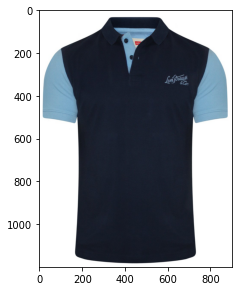

In [105]:
w=30
h=10
fig=plt.figure(figsize=(20, 10))
rows=int(len(data['url'])/5)+1
columns = 5
for i in range(0, len(data['url'])):
  f = urllib.request.urlopen(data['url'][i])
  a = plt.imread(f,0)
  fig.add_subplot(rows, columns, i+1)
  plt.imshow(a)
plt.show()

In [106]:
JSON_CONTENT_TYPE

'application/json'

In [116]:
input_object=input_fn(request_body, content_type=JSON_CONTENT_TYPE)
len(input_object)

7

In [125]:
request_body

'{"url": ["https://static.cilory.com/244534-thickbox_default/levis-navy-polo-t-shirt.jpg"], "add_words": [], "sub_words": ["stripes"], "gender": "All", "item_type": "All", "topk": 5}'

In [161]:
prediction['index']=[post_process(x) for x in prediction['index']]
prediction['index'] 

['/content/drive/MyDrive/Fellowship.ai/embedder/training_img/20506.jpg',
 '/content/drive/MyDrive/Fellowship.ai/embedder/training_img/20506.jpg',
 '/content/drive/MyDrive/Fellowship.ai/embedder/training_img/20506.jpg',
 '/content/drive/MyDrive/Fellowship.ai/embedder/training_img/20506.jpg',
 '/content/drive/MyDrive/Fellowship.ai/embedder/training_img/20506.jpg']

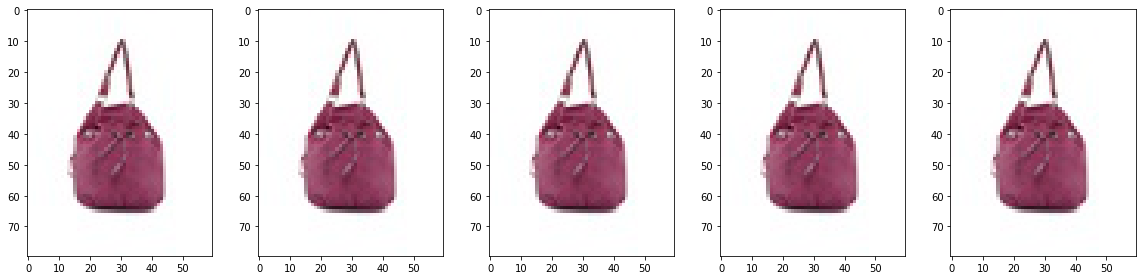

In [164]:
import urllib



hdr = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.11 (KHTML, like Gecko) Chrome/23.0.1271.64 Safari/537.11',
       'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
       'Accept-Charset': 'ISO-8859-1,utf-8;q=0.7,*;q=0.3',
       'Accept-Encoding': 'none',
       'Accept-Language': 'en-US,en;q=0.8',
       'Connection': 'keep-alive'}

w=30
h=10
fig=plt.figure(figsize=(20, 10))
rows=int(len(prediction['index'])/5)+1
columns = 5
for i in range(0, len(prediction['index'])):
  #req=urllib.request.Request(prediction['index'][i], headers=hdr)
  req = prediction['index'][i]
  #f = urllib.request.urlopen(req)
  a = plt.imread(req,0)
  fig.add_subplot(rows, columns, i+1)
  plt.imshow(a)
plt.show()